# Regularized Linear Model (Question 2 from Hw2)
## Javier Palomares

Followed steps from https://www.kaggle.com/apapiu/regularized-linear-models

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Data preprocessing:
We're not going to do anything fancy here:

* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3bdb17a20>,
      dtype=object)

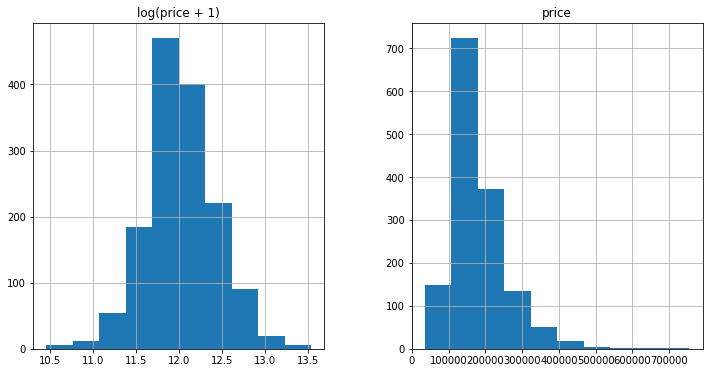

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
# log transform the sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

# get the numberical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# compute the skeweness factor of features
# take features with factor greater than .75
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# take the log of all skewed features
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [8]:
display(all_data)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.000000,0.0,NaN,NaN,NaN,0.000000,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.000000,0.0,NaN,NaN,NaN,0.000000,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.000000,0.0,NaN,NaN,NaN,0.000000,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.000000,0.0,NaN,NaN,NaN,0.000000,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.000000,0.0,NaN,NaN,NaN,0.000000,12,2008,WD,Normal
5,3.931826,RL,4.454347,9.555064,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.000000,0.0,NaN,MnPrv,Shed,6.552508,10,2009,WD,Normal
6,3.044522,RL,4.330733,9.218804,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.000000,0.0,NaN,NaN,NaN,0.000000,8,2007,WD,Normal
7,4.110874,RL,NaN,9.247925,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.000000,0.0,NaN,NaN,Shed,5.860786,11,2009,WD,Normal
8,3.931826,RM,3.951244,8.719481,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.000000,0.0,NaN,NaN,NaN,0.000000,4,2008,WD,Abnorml
9,5.252273,RL,3.931826,8.912069,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0.000000,0.0,NaN,NaN,NaN,0.000000,1,2008,WD,Normal


In [10]:
# Convert categorical variable into dummy/indicator variables
all_data = pd.get_dummies(all_data)

In [13]:
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [14]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par